# Fig 5 waveform shape gif

This notebook creates an animated visualizer showing how waveform shape can influence estimates.

Based on Fig 5 (a-c) of the oscillation methods paper.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from fooof import Bands

from neurodsp.filt import filter_signal
from neurodsp.timefrequency import amp_by_time
from neurodsp.spectral import compute_spectrum, trim_spectrum
from neurodsp.sim import sim_oscillation, sim_powerlaw

from bycycle.features import compute_features

In [2]:
import seaborn as sns
sns.set_context('poster')

In [3]:
# Import custom code
from code.utils import sweep_values
from code.measures import compute_abs_power, compute_pac
from code.plts import plot_timeseries, plot_bar, plot_spectra, get_max_lim
from code.gif import clear_output, _gif_plot_output

## SETTINGS

In [4]:
# Simulation settings
n_seconds = 10
fs = 1000

cf = 10
exp = -1

In [5]:
# Band definitions
BANDS = Bands({'alpha' : [8, 12],
               'beta' : [12, 35]})

alpha_color = '#1882d9'
beta_color = '#a218d9'

In [6]:
# Settings for using ByCycle
burst_detection_kwargs = {
    "amplitude_fraction_threshold": 0.0,
    "amplitude_consistency_threshold": 0.0,
    "period_consistency_threshold": 0.0,
    "monotonicity_threshold": 0.0}

In [7]:
# Plot settings
psd_range = [3, 35]
colors = ['black', 'green']

In [8]:
# Create the set of rdsym values to sweep across
mid, low, high = 0.5, 0.1, 0.9
step = 0.1
rdsyms = sweep_values(mid, low, high, step)

In [9]:
# Set whether to save out
SAVE = False

## DEFINE AXES

In [10]:
def make_axes():
    
    fig = plt.figure(figsize=(12, 4), constrained_layout=True)
    gs = fig.add_gridspec(2, 5)

    ax1 = fig.add_subplot(gs[0, 0:3])
    ax2 = fig.add_subplot(gs[1, 0])
    ax3 = fig.add_subplot(gs[1, 1])
    ax4 = fig.add_subplot(gs[1, 2])
    ax5 = fig.add_subplot(gs[0:, 3:])
    
    return fig, ax1, ax2, ax3, ax4, ax5

## SIMULATE SIGNAL

In [11]:
# Simulate aperiodic and periodic signal components
ap = sim_powerlaw(n_seconds, fs, exp)

rdsym = 0.75
osc = sim_oscillation(n_seconds, fs, cf, cycle='asine', rdsym=rdsym)

In [12]:
# Compute derived measures of interest
filted = filter_signal(osc, fs, 'bandpass', (cf-2, cf+2))

freqs, powers = trim_spectrum(*compute_spectrum(osc + ap, fs), psd_range)

df = compute_features(osc, fs, f_range=(cf - 2, cf + 2),
                      burst_detection_kwargs=burst_detection_kwargs)

In [13]:
# Compute band-filtered traces and power measures
alpha_filt = filter_signal(osc, fs, 'bandpass', BANDS.alpha)
beta_filt = filter_signal(osc, fs, 'bandpass', BANDS.beta)

alpha = np.nanmean(amp_by_time(alpha_filt, fs))
beta = np.nanmean(amp_by_time(beta_filt, fs))

In [14]:
# Compute phase amplitude coupling
bins, pac = compute_pac(alpha_filt, beta_filt)
pac = np.nanmax(pac) - np.nanmin(pac)

In [15]:
# Compute comparison sine wave
sine_osc = sim_oscillation(n_seconds, fs, cf, cycle='asine', rdsym=0.5)
freqs_sine, powers_sine = trim_spectrum(*compute_spectrum(sine_osc + ap, fs), psd_range)

alpha_sine_filt = filter_signal(sine_osc, fs, 'bandpass', BANDS.alpha)
beta_sine_filt = filter_signal(sine_osc, fs, 'bandpass', BANDS.beta)
alpha_sine = np.nanmean(amp_by_time(alpha_sine_filt, fs))
beta_sine = np.nanmean(amp_by_time(beta_sine_filt, fs))

bins, pac_sine = compute_pac(alpha_sine_filt, beta_sine_filt)
pac_sine = np.nanmax(pac_sine) - np.nanmin(pac_sine)

## EXAMPLE PLOT

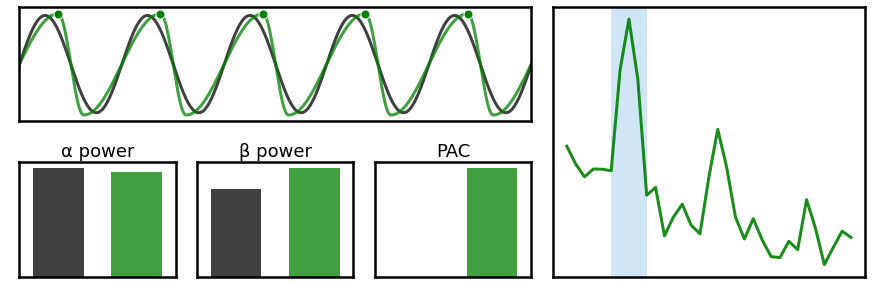

In [16]:
# Create an example panel of the visualizer
fig, ax1, ax2, ax3, ax4, ax5 = make_axes()
plot_timeseries([filted, osc], colors=colors, alpha=0.75,
                xlim=[1000, 1500], ylim=[-1.6, 1.6], ax=ax1)

ax1.plot(df.sample_peak, df.volt_peak, ".",
        color='green', markersize=18, markeredgecolor='white')

plot_bar(alpha_sine, alpha, title='α power', 
         color=colors, alpha=0.75, ax=ax2)
plot_bar(beta_sine, beta, title='β power',
         color=colors, alpha=0.75, ax=ax3)
plot_bar(np.nanmax(pac_sine), np.nanmax(pac), title='PAC',
         color=colors, alpha=0.75,ax=ax4)
plot_spectra(freqs, powers, colors=colors[1], alpha=0.9,
             shade_ranges=[BANDS.alpha], shade_colors=[alpha_color],
             log_freqs=False, ax=ax5)

## BUILDER FUNCTION

In [17]:
def build_all(rdsyms, sleep=0.5, save=False):
    
    ## Setup
    
    # Precompute signals and measures
    oscs, filteds, powerss, dfs, alphas, betas, pacs = [], [], [], [], [], [], []
    for rdsym in rdsyms:
        
        osc = sim_oscillation(n_seconds, fs, cf, cycle='asine', rdsym=rdsym)
        oscs.append(osc)
        
        filteds.append(filter_signal(osc, fs, 'bandpass', (cf-2, cf+2)))
        
        freqs, powers = trim_spectrum(*compute_spectrum(osc + ap, fs), psd_range)
        powerss.append(powers)
        
        dfs.append(compute_features(osc, fs, f_range=(cf - 2, cf + 2),
                                   burst_detection_kwargs=burst_detection_kwargs))
        
        alpha_filt = filter_signal(osc, fs, 'bandpass', BANDS.alpha)
        beta_filt = filter_signal(osc, fs, 'bandpass', BANDS.beta)

        alphas.append(np.nanmean(amp_by_time(alpha_filt, fs)))
        betas.append(np.nanmean(amp_by_time(beta_filt, fs)))

        bins, pac = compute_pac(alpha_filt, beta_filt)
        pacs.append(np.nanmax(pac) - np.nanmin(pac))

    
    ## Create builds
    for b_ind, (osc, filted, powers, df, alpha, beta, pac) in \
        enumerate(zip(oscs, filteds, powerss, dfs, alphas, betas, pacs)):

        clear_output(wait=True)
        
        fig, ax1, ax2, ax3, ax4, ax5 = make_axes()
    
        plot_timeseries([filted, osc], colors=['black', 'green'],
                        alpha=0.75, xlim=[1000, 1500], ylim=[-1.6, 1.6], ax=ax1)

        ax1.plot(df.sample_peak, df.volt_peak, ".",
                 color='green', markersize=16, markeredgecolor='white')

        plot_bar(alpha_sine, alpha, title='α power',
                 color=colors, ylim=[0.0, get_max_lim(alphas)], ax=ax2)
        plot_bar(beta_sine, beta, title='β power',
                 color=colors, ylim=[0.25, get_max_lim(betas)], ax=ax3)
        plot_bar(pac_sine, pac, title='PAC',
                 color=colors, ylim=[0., get_max_lim(pacs)], ax=ax4)
        plot_spectra(freqs, powers, colors=colors[1], alpha=0.9,
                     shade_ranges=[BANDS.alpha], shade_colors=[alpha_color],
                     log_freqs=False, ax=ax5)
    
        _gif_plot_output(fig, save, b_ind, 'fig5', sleep)

## ANIMATED PLOT

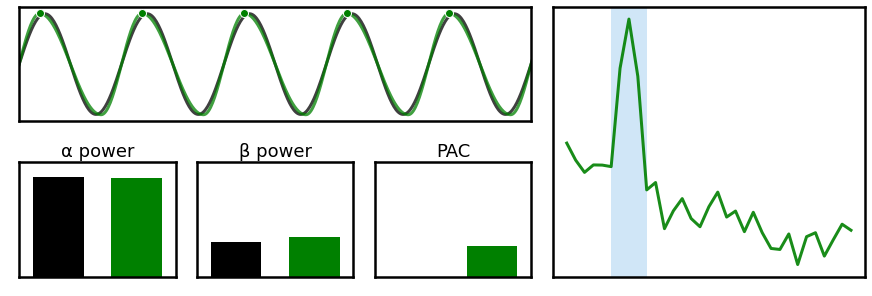

In [18]:
# Create the animated plot
build_all(rdsyms, save=SAVE)